In [ ]:
%pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph==0.1.17 tavily-python langchainhub gradio

In [2]:
%pip install pymongo -qqqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 11.4 MB/s eta 0:00:00


In [ ]:
%pip install rich
from rich import print

In [4]:
from langchain_core.pydantic_v1 import BaseModel
from typing import TypedDict, Annotated, List
from rich import print

class Attributes(BaseModel):
    attributes: List[str]

In [6]:
from langchain_openai import ChatOpenAI
from google.colab import userdata

model = ChatOpenAI(model="gpt-4o", temperature=0.2, openai_api_key=userdata.get('openai'))

### Get Attributes

In [7]:
RESEARCH_PROMPT = """

##Your Role:
You are an expert in Recommendation Systems, particularly in the Upselling domain. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

##Task:

Identify the category of the product (e.g., "BMW 328i belongs to Luxury Sedan Cars").
Develop a list of up to 10 key attributes, each with a brief one-line description, that a user would consider when comparing the product to more expensive or higher-end models.
Example:

```
{
  "Attribute 1": "Description 1",
  "Attribute 2": "Description 2",
  ...
  "Attribute 10": "Description 10"
}
```

"""

from typing import TypedDict, Annotated, List

class AgentState(TypedDict):
    user_query: str
    attribute_results: List[str]
    high_end_model_summarization: List[str]
    high_end_model_comparison: List[str]
    review_comments: str
    draft_number: int
    max_reviews: int

import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

def get_attribute_node(state: AgentState):
  print ("Research Agent executing ...")
  input_message = "User query: " + state['user_query']
  draft_number = 0
  messages = model.with_structured_output(Attributes).invoke([
        SystemMessage(content=RESEARCH_PROMPT),
        HumanMessage(content=input_message)
    ])
  #response = model.invoke(messages)
  return {"attribute_results": messages.attributes, "draft_number": draft_number}

### Get High End Models

In [9]:
from dataclasses import Field
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, Annotated, List
from langchain_core.output_parsers import PydanticOutputParser

class high_end_product(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarization for Original Product")
    product1: str = Field(title="Product 1", description="Summarization Product 1")
    product2: str = Field(title="Product 2", description="Summarization Product 2")
    product3: str = Field(title="Product 3", description="Summarization Product 3")
    product4: str = Field(title="Product 4", description="Summarization Product 4")


pydantic_parser  = PydanticOutputParser(pydantic_object=high_end_product)
format_instructions = pydantic_parser.get_format_instructions()
print(format_instructions)



The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": 
"array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": 
["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"original_product": {"title": "Original Product", "description": "Summarization for Original 
Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Summarization Product 1", "type": 
"string"}, "product2": {"title": "Product 2", "description": "Summarization Product 2", "type": "string"}, 
"product3": {"title": "Product 3", "description": "Summarization Product 3", "type": "string"}, "product4": 
{"title": "Product 4", "description": "Summarization Product 4", "type": "string"}}, "required": 
["original_product", "product1", "product2", "product3", "product4"]}
```

In [10]:
from typing_extensions import final




def get_high_end_model(state: AgentState):
  HIGH_END_PRODUCTS_PROMPT = """

    ##Your Role:
    You are expert Technical Sales agent who has a knowledge of variety of products,and details about them and you know everything a customer want to know before buying a product. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

    ##Task:

    - Identify the price of user given product.
    - Indentify atmost 4 high end products from the one user suggested. It can be from the same brand or other brands. The key is they should be comparable. **The price of high end models should be higher the exact price of all items**
    - Summarize the finding for each product in DETAIL, including the original user given product.
    - Make sure the summary **covers all the aspects of this attribute list {attributes} in DETAIL**. Summary should be between 300 words

    ##Output Format: {format_instructions}
    ```json
    {{
      "orignal_product": "orignal_product: Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Product1 Price : Summarization Product 1",
      "product2": "Product Name2: Product2 Price : Summarization Product 2",
      "product3": "Product Name3: Product3 Price : Summarization Product 3",
      "product4": "Product Name4: Product4 Price : Summarization Product 4"
    }}
    ```
    Make sure each product price is higher thant the original product price and its explicitly mentioned in the output.
    """


  REVISE_HIGH_END_PRODUCTS_PROMPT = """
    ##Your Role:
    You are expert Technical Sales agent who has a knowledge of variety of products,and details about them and you know everything a customer want to know before buying a product. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

    ##Your Task:
    - This is the draft comparing original product with high end models. {high_end_comparisons}
    - review the comments for each product {reviews},
    - if its satisfied, great return the same product with the same summary, DO NOT CHANGE ANYTHING
    - if not, act on the advise, and make necessary changes using the below guidelines.

    ### Guidelines:
    - Identify the price of user given product.
    - Indentify what the advise is for a particular product, if it needs clarification; provide to address the issue and return the same product with the necessary changes.
    - if price lower is the issue and identify a new product, summarize the product in DETAIL. Make sure the summary covers all the aspects of this attribute list {attributes} in DETAIL. Summary should be between 300 words

    ## Updated High End Products Summary:
    ###Output Format: {format_instructions}
    ```json
    {{
      "orignal_product": "orignal_product: Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Product1 Price : Summarization Product 1",
      "product2": "Product Name2: Product2 Price : Summarization Product 2",
      "product3": "Product Name3: Product3 Price : Summarization Product 3",
      "product4": "Product Name4: Product4 Price : Summarization Product 4"
    }}
    ```
    Make sure each product price is higher thant the original product price and its explicitly mentioned in the output.


  """
  attribute_list = ";".join(state['attribute_results'] or [])
  user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
  if (state['review_comments'] is not None and state['review_comments'] != ""):
    print ("Revising High End Models ...")
    final_prompt = REVISE_HIGH_END_PRODUCTS_PROMPT.format(
        high_end_comparisons=state['high_end_model_comparison'],
        reviews=state['review_comments'],
        attributes=attribute_list,
        format_instructions=format_instructions)
  else:
    print ("Getting High End Models ...")
    final_prompt = HIGH_END_PRODUCTS_PROMPT.format(attributes=attribute_list, format_instructions=format_instructions)
  response = model.invoke([
        SystemMessage(content=final_prompt),
        user_message
    ])
  output_summarization = response.content
  final_output_summarization = pydantic_parser.parse(output_summarization)
  return {"high_end_model_summarization": final_output_summarization}

### High End Model Comparison

In [11]:
class high_end_product_comparison(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarizing for Original Product")
    product1: str = Field(title="Product 1", description="Summarizing why paying higher for product 1 is better")
    product2: str = Field(title="Product 2", description="Summarizing why paying higher for product 2 is better")
    product3: str = Field(title="Product 3", description="Summarizing why paying higher for product 3 is better")
    product4: str = Field(title="Product 4", description="Summarizing why paying higher for product 4 is better")


pydantic_parser_comparison  = PydanticOutputParser(pydantic_object=high_end_product_comparison)
format_instructions_comparison = pydantic_parser_comparison.get_format_instructions()
print(format_instructions_comparison)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": 
"array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": 
["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"original_product": {"title": "Original Product", "description": "Summarizing for Original 
Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Summarizing why paying higher for 
product 1 is better", "type": "string"}, "product2": {"title": "Product 2", "description": "Summarizing why paying 
higher for product 2 is better", "type": "string"}, "product3": {"title": "Product 3", "description": "Summarizing 
why paying higher for product 3 is better", "type": "string"}, "product4": {"title": "Product 4", "description": 
"Summarizing why paying higher for product 4 is better", "type": "string"}}, "required": ["original_product", 
"product1", "product2", "product3", "product4"]}
```

In [12]:
def get_high_end_model_comparison(state: AgentState):
  HIGH_END_PRODUCTS_COMPARISON_PROMPT = """

    ##Your Role:
    You are expert critique agent who is expert in reading a lot of product summarization and ability to distinctly identify key qualities of a product.
    ##Task: Here is the summary for the original product and its high end models. {high_end_models}

    - Understand the original products and its features and qualities.
    - Compare and reason out why paying higher price for a product is better than the original product.
    - List key points with clarity that make it worth paying for the higher end model.
    - **Each listed point should directly compare with the original product**

    ##Output Format: {format_instructions}
    ```
    {{
      "orignal_product": "Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Price:  <Reason for why paying higher for product 1 is better in bullet points>",
      "product2": "Product Name2: Price:  <Reason for why paying higher for product 2 is better in bullet points>",
      "product3": "Product Name3: Price:  <Reason for why paying higher for product 3 is better in bullet points>",
      "product4": "Product Name4: Price:  <Reason for why paying higher for product 4 is better in bullet points>"
    }}

    Make sure each product is compared with the original product. Make sure its a json in the output format provided
    """
  high_end_models = ";".join(str(item) for item in (state['high_end_model_summarization'] or []))
  user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
  final_prompt = HIGH_END_PRODUCTS_COMPARISON_PROMPT.format(high_end_models=high_end_models, format_instructions=format_instructions_comparison)
  response = model.invoke([
        SystemMessage(content=final_prompt),
        user_message
    ])
  output = response.content
  final_output = pydantic_parser_comparison.parse(output)
  if (state.get("draft_number") is not None):
      draft_number = state.get("draft_number")

  return {"high_end_model_comparison": final_output,
          "draft_number": draft_number + 1}

### Reflection Node

In [14]:
class reflection_on_comparison(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarizing for Original Product")
    product1: str = Field(title="Product 1", description="Review Comments for product 1")
    product2: str = Field(title="Product 2", description="Review Comments for product 2")
    product3: str = Field(title="Product 3", description="Review Comments for product 3")
    product4: str = Field(title="Product 4", description="Review Comments for product 4")

pydantic_parser_reflection  = PydanticOutputParser(pydantic_object=reflection_on_comparison)
format_instructions_reflection = pydantic_parser_reflection.get_format_instructions()
print(format_instructions_reflection)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": 
"array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": 
["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"original_product": {"title": "Original Product", "description": "Summarizing for Original 
Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Review Comments for product 1", 
"type": "string"}, "product2": {"title": "Product 2", "description": "Review Comments for product 2", "type": 
"string"}, "product3": {"title": "Product 3", "description": "Review Comments for product 3", "type": "string"}, 
"product4": {"title": "Product 4", "description": "Review Comments for product 4", "type": "string"}}, "required": 
["original_product", "product1", "product2", "product3", "product4"]}
```

In [15]:


def reflection_node(state: AgentState):
    REFLECTION_PROMPT = """

    ##Your Role:
    You are an expert in Recommendation Systems, particularly in the Upselling domain. Your task is analyze the output of recommendations provided to you. You would want to make sure overall
    objective of maximize revenue by encouraging customers to purchase higher-value products or add-on items that complement their existing purchase intentions is achieved

    This is the draft comparing original product with high end models. {draft_summarization}

    ##Task:
    1. Make sure the price of the higher end items are higher than the original product price
    2. Make sure if the reasoning provided is correct or not.
    3. if convinced return "Satisfied" and if you are not convinced the reasoning  provided to for that product. Include the product name in the review.
    4. Advise to change the product if price is lower than the original product price.
    5. Do not provide more context about the product, the task is to **JUDGE** if you are satisfied or not and the high price condition is met.

    ## Output Format: {format_instructions}
    ```json
    {{
      "product1": "Review Comments for product 1 it should be satisfied or the review",
      "product2": "Review Comments for product 2 it should be satisfied or the review",
      "product3": "Review Comments for product 3 it should be satisfied or the review",
      ...
      "product4": "Review Comments for product 4 it should be satisfied or the review"
    }}
    ```

    Make sure each product is compared with the original product. Make sure its a json in the output format provided
    """
    print ("Review Agent executing ...")
    #draft_summarization = ";".join(state['high_end_model_comparison'] or [])
    print(state['high_end_model_comparison'])
    draft_summarization = ";".join(str(item) for item in (state['high_end_model_comparison'] or []))
    user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
    final_prompt_reflection = REFLECTION_PROMPT.format(draft_summarization=draft_summarization, format_instructions=format_instructions_reflection)
    response = model.invoke([
          SystemMessage(content=final_prompt_reflection),
          user_message
      ])
    output_reflection = response.content
    final_output_reflection = pydantic_parser_reflection.parse(output_reflection)

    return {"review_comments": final_output_reflection}

def agent_goal(state: AgentState):
  draft_number = state["draft_number"]
  max_reviews = state["max_reviews"]
  output_reflection = state["review_comments"]
  if draft_number > max_reviews:
    print ("End of Agent Execution")
    return "AGENT_END"
  elif output_reflection.product1 == "Satisfied" and output_reflection.product2 == "Satisfied" and output_reflection.product3 == "Satisfied" and output_reflection.product4 == "Satisfied":
    print ("End of Agent Execution since all products are satisfied")
    return "AGENT_END"
  else:
    print ("Continue Agent Execution")
    return "AGENT_CONTINUE"

## Running an Agent

In [16]:
from langgraph.graph import StateGraph, END

upsell_graph = StateGraph(AgentState)
upsell_graph.add_node("get_attributes", get_attribute_node)
upsell_graph.add_node("get_high_end_model", get_high_end_model)
upsell_graph.add_node("get_high_end_model_comparison", get_high_end_model_comparison)
upsell_graph.add_node("reflection", reflection_node)




upsell_graph.add_edge("get_attributes", "get_high_end_model")
upsell_graph.add_edge("get_high_end_model", "get_high_end_model_comparison")
upsell_graph.add_edge("get_high_end_model_comparison", "reflection")
upsell_graph.add_conditional_edges("reflection", agent_goal, {"AGENT_END": END, "AGENT_CONTINUE": "get_high_end_model"})


In [17]:
upsell_graph.set_entry_point("get_attributes")


In [18]:
upsell_recommendation_agent = upsell_graph.compile()

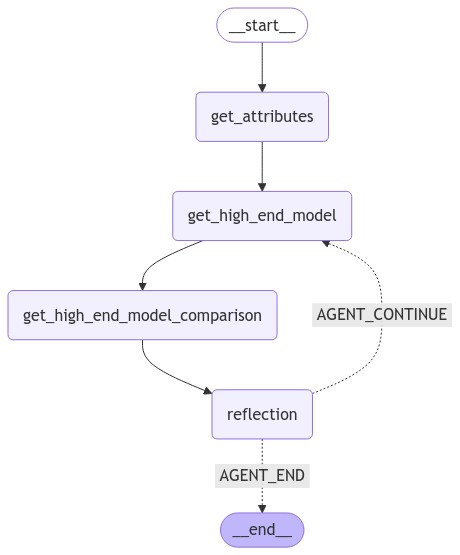

In [19]:
from IPython.display import Image, display

display(Image(upsell_recommendation_agent.get_graph().draw_mermaid_png()))

In [20]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('lsmith')
os.environ['LANGCHAIN_PROJECT'] = "agent_report"

In [21]:
output = upsell_recommendation_agent.invoke({'user_query': "Dasani Water",
                                  "max_reviews": 2,})

#"Traeger Pro Blend All-Natural Wood Grilling Pellets"

Research Agent executing ...

Getting High End Models ...

Review Agent executing ...

high_end_product_comparison(
    original_product='Dasani Water: $1.50 for a 20 oz bottle. Dasani is a well-known brand owned by Coca-Cola, 
recognized for its widespread availability and affordability. It sources its water from local municipal supplies, 
which is then purified through a process involving reverse osmosis. The purification process ensures a high level 
of purity, removing impurities and contaminants. Dasani uses recyclable PET plastic bottles, focusing on 
sustainability with their PlantBottle initiative. It adds a proprietary blend of minerals for taste, including 
magnesium sulfate, potassium chloride, and salt, giving it a clean and crisp taste. Dasani has made efforts to 
reduce its environmental footprint through recyclable packaging. Positioned as an affordable bottled water option, 
it is widely available in supermarkets, convenience stores, and vending machines. It provides hydration with added 
minerals for taste, but no significant health benefits over other purified waters.',
    product1="Fiji Water: $2.50 for a 16.9 oz bottle. - Sourced from an artesian aquifer in Fiji, providing a 
unique and exotic origin compared to Dasani's municipal sources. - Naturally filtered through volcanic rock, 
offering a high purity level without the need for reverse osmosis. - Contains natural minerals like silica, 
calcium, and magnesium, which contribute to a smooth and soft taste, potentially offering skin health benefits. - 
Distinctive square-shaped bottles add a premium aesthetic appeal. - Despite its higher carbon footprint due to 
transportation, the premium pricing reflects its exotic source and natural filtration process.",
    product2="Evian Water: $2.00 for a 16.9 oz bottle. - Sourced from the French Alps, offering a naturally pure 
and mineral-balanced water compared to Dasani's municipal source. - Naturally filtered over 15 years, ensuring a 
unique natural purification process. - Balanced mineral content, including calcium and magnesium, supports overall 
health, unlike Dasani's added minerals for taste. - Committed to reducing carbon emissions, aligning with 
sustainability efforts similar to Dasani. - The premium price reflects the natural filtration process and health 
benefits associated with its mineral content.",
    product3="Voss Water: $2.75 for a 16.9 oz bottle. - Sourced from an artesian source in Norway, offering a 
naturally pure water with minimal processing compared to Dasani's reverse osmosis purification. - Iconic 
cylindrical glass bottles provide a luxury appeal and are recyclable, though heavier to transport. - Low mineral 
content makes it suitable for low-sodium diets, offering a different health benefit compared to Dasani's added 
minerals for taste. - High-end pricing reflects its luxury branding and stylish packaging, appealing to a different
market segment.",
    product4="Smartwater: $1.75 for a 20 oz bottle. - Vapor-distilled for high purity, offering a different 
purification method compared to Dasani's reverse osmosis. - Added electrolytes for taste provide a hint of 
sweetness and can aid in hydration, offering a functional benefit over Dasani's added minerals for taste. - Sleek 
PET bottles with a modern design, focusing on sustainable packaging similar to Dasani. - Priced slightly higher 
than Dasani due to the added electrolytes, appealing to those seeking enhanced hydration benefits."
)

End of Agent Execution since all products are satisfied

In [22]:

print(output)

{
    'user_query': 'Dasani Water',
    'attribute_results': [
        'Brand Reputation',
        'Water Source',
        'Purity Level',
        'Packaging Quality',
        'Mineral Content',
        'Taste Profile',
        'Environmental Impact',
        'Price Point',
        'Availability',
        'Health Benefits'
    ],
    'high_end_model_summarization': high_end_product(
        original_product='Dasani Water: $1.50 for a 20 oz bottle. Dasani is a well-known brand owned by Coca-Cola, 
recognized for its widespread availability and affordability. It sources its water from local municipal supplies, 
which is then purified through a process involving reverse osmosis. The purification process ensures a high level 
of purity, removing impurities and contaminants. Dasani uses recyclable PET plastic bottles, focusing on 
sustainability with their PlantBottle initiative. It adds a proprietary blend of minerals for taste, including 
magnesium sulfate, potassium chloride, and salt, giving it a clean and crisp taste. Dasani has made efforts to 
reduce its environmental footprint through recyclable packaging. Positioned as an affordable bottled water option, 
it is widely available in supermarkets, convenience stores, and vending machines. It provides hydration with added 
minerals for taste, but no significant health benefits over other purified waters.',
        product1='Fiji Water: $2.50 for a 16.9 oz bottle. Known for its premium quality and unique source, Fiji 
Water is sourced from an artesian aquifer in Viti Levu, Fiji. It is naturally filtered through volcanic rock, 
resulting in a high purity level. The high-quality PET bottles have a distinctive square shape. Rich in silica, 
calcium, and magnesium, Fiji Water has a smooth and soft taste due to its natural mineral content. It has been 
criticized for its carbon footprint due to transportation. Its premium pricing reflects its exotic source. 
Available in upscale grocery stores and restaurants, its high silica content is believed to support skin health.',
        product2='Evian Water: $2.00 for a 16.9 oz bottle. Renowned for its natural purity and mineral balance, 
Evian Water is sourced from the French Alps and naturally filtered over 15 years. It comes in classic PET bottles 
with a focus on sustainability. With balanced minerals including calcium and magnesium, Evian has a neutral and 
refreshing taste. Committed to reducing carbon emissions, its premium price is due to the natural filtration 
process. Widely available in supermarkets and health stores, its balanced mineral content supports overall 
health.',
        product3='Voss Water: $2.75 for a 16.9 oz bottle. Known for its luxury appeal and stylish packaging, Voss 
Water is sourced from an artesian source in Norway. It is naturally pure with minimal processing. The iconic 
cylindrical glass bottles are recyclable but heavier to transport. With low mineral content, Voss has a crisp and 
clean taste with a smooth finish. Its high-end pricing reflects its luxury branding. Available in high-end 
restaurants and hotels, its low mineral content is suitable for low-sodium diets.',
        product4='Smartwater: $1.75 for a 20 oz bottle. Popular for its vapor-distilled purity and added 
electrolytes, Smartwater is sourced from municipal sources and vapor-distilled. It has high purity through vapor 
distillation and comes in sleek PET bottles with a modern design. With added electrolytes for taste, Smartwater has
a clean and crisp taste with a hint of sweetness. It focuses on sustainable packaging. Priced slightly higher than 
Dasani due to added electrolytes, it is widely available in stores and fitness centers. The added electrolytes can 
aid in hydration.'
    ),
    'high_end_model_comparison': high_end_product_comparison(
        original_product='Dasani Water: $1.50 for a 20 oz bottle. Dasani is a well-known brand owned by Coca-Cola, 
recognized for its widespread availability and affordability. It sources its

In [23]:
from rich import print
print(output['high_end_model_comparison'].product1)

Fiji Water: $2.50 for a 16.9 oz bottle. - Sourced from an artesian aquifer in Fiji, providing a unique and exotic 
origin compared to Dasani's municipal sources. - Naturally filtered through volcanic rock, offering a high purity 
level without the need for reverse osmosis. - Contains natural minerals like silica, calcium, and magnesium, which 
contribute to a smooth and soft taste, potentially offering skin health benefits. - Distinctive square-shaped 
bottles add a premium aesthetic appeal. - Despite its higher carbon footprint due to transportation, the premium 
pricing reflects its exotic source and natural filtration process.

In [24]:
from rich import print
print(output['high_end_model_comparison'].product2)

Evian Water: $2.00 for a 16.9 oz bottle. - Sourced from the French Alps, offering a naturally pure and 
mineral-balanced water compared to Dasani's municipal source. - Naturally filtered over 15 years, ensuring a unique
natural purification process. - Balanced mineral content, including calcium and magnesium, supports overall health,
unlike Dasani's added minerals for taste. - Committed to reducing carbon emissions, aligning with sustainability 
efforts similar to Dasani. - The premium price reflects the natural filtration process and health benefits 
associated with its mineral content.

In [25]:
from rich import print
print(output['high_end_model_comparison'].product3)

Voss Water: $2.75 for a 16.9 oz bottle. - Sourced from an artesian source in Norway, offering a naturally pure 
water with minimal processing compared to Dasani's reverse osmosis purification. - Iconic cylindrical glass bottles
provide a luxury appeal and are recyclable, though heavier to transport. - Low mineral content makes it suitable 
for low-sodium diets, offering a different health benefit compared to Dasani's added minerals for taste. - High-end
pricing reflects its luxury branding and stylish packaging, appealing to a different market segment.

In [26]:
from rich import print
print(output['high_end_model_comparison'].product4)

Smartwater: $1.75 for a 20 oz bottle. - Vapor-distilled for high purity, offering a different purification method 
compared to Dasani's reverse osmosis. - Added electrolytes for taste provide a hint of sweetness and can aid in 
hydration, offering a functional benefit over Dasani's added minerals for taste. - Sleek PET bottles with a modern 
design, focusing on sustainable packaging similar to Dasani. - Priced slightly higher than Dasani due to the added 
electrolytes, appealing to those seeking enhanced hydration benefits.

In [27]:
print(output['high_end_model_comparison'].original_product)

Dasani Water: $1.50 for a 20 oz bottle. Dasani is a well-known brand owned by Coca-Cola, recognized for its 
widespread availability and affordability. It sources its water from local municipal supplies, which is then 
purified through a process involving reverse osmosis. The purification process ensures a high level of purity, 
removing impurities and contaminants. Dasani uses recyclable PET plastic bottles, focusing on sustainability with 
their PlantBottle initiative. It adds a proprietary blend of minerals for taste, including magnesium sulfate, 
potassium chloride, and salt, giving it a clean and crisp taste. Dasani has made efforts to reduce its 
environmental footprint through recyclable packaging. Positioned as an affordable bottled water option, it is 
widely available in supermarkets, convenience stores, and vending machines. It provides hydration with added 
minerals for taste, but no significant health benefits over other purified waters.